Dependencies

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import pickle
import zarr
import os
import napari
import numpy as np

from cellcanvas_spp.features import superpixel_regionprops_features, superpixel_cellcanvas_features
from cellcanvas_spp.ground_truth import ground_truth_count
from cellcanvas_spp.eval import evaluate_spp_features
from cellcanvas_spp.features import superpixel_cellcanvas_features


User-specific path

In [2]:
# Teun:
# DATA_DIR = '/Users/teun.huijben/Documents/code/github/superpixels/data/copick_10439/dataset_run_16194.pickle'
# DATA_DIR = '/Users/teun.huijben/Documents/code/github/superpixels/data/copick_10439/dataset_run_16186_hmin_0p0025.pickle'
# DATA_DIR = '/Users/teun.huijben/Documents/code/github/superpixels/data/copick_10439/dataset_run_16186_hmin_0p0015.pickle'
# DATA_DIR = '/Users/teun.huijben/Documents/code/github/superpixels/data/copick_10439/dataset_run_16186_hmin_0p0005.pickle'

# DATA_DIR = '/Users/teun.huijben/Documents/code/github/superpixels/data/copick_10439/dataset_run_16193_loadedSegm.pickle'
# DATA_DIR = '/Users/teun.huijben/Documents/code/github/superpixels/data/copick_10439/dataset_run_16193_loadedSegm10000.pickle'

# DATA_DIR = '/Users/teun.huijben/Documents/code/github/superpixels/data/copick_10439/dataset_run_16191_loadedSegm.pickle'
# DATA_DIR = '/Users/teun.huijben/Documents/code/github/superpixels/data/copick_10439/dataset_run_16191_loadedSegm10000.pickle'
DATA_DIR = '/Users/teun.huijben/Documents/code/github/superpixels/data/copick_10439/dataset_run_16191_loadedSegm10000.pickle'


# Kevin:
# DATA_DIR = '../dataset_run_16194.pickle'

Load data

In [3]:
# Load data from a file
with open(DATA_DIR, 'rb') as f:  # 'rb' means read in binary mode
    data = pickle.load(f)

superpixels = data['superpixels']
tomogram = data['image']
ground_truth = data['label']

Plot for sanity

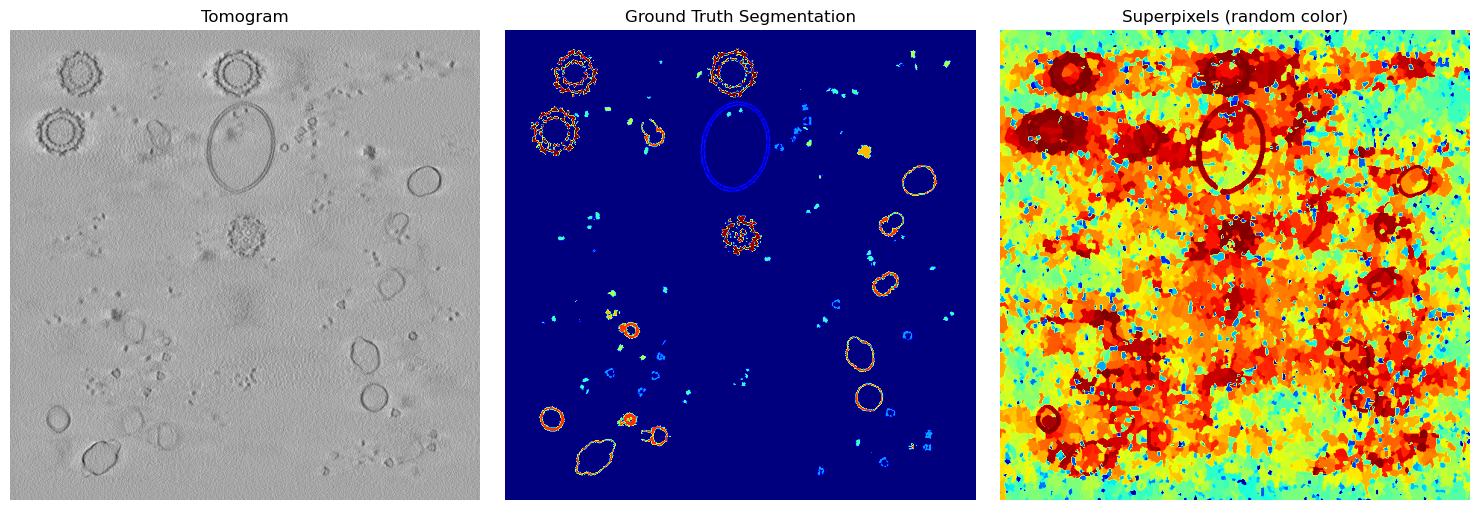

number of superpixels: (71871,)


In [4]:
# Plot the images
z_slice = 62

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Tomogram')
plt.imshow(tomogram[z_slice],cmap="gray")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Ground Truth Segmentation')
plt.imshow(ground_truth[z_slice], cmap="jet")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Superpixels (random color)')
plt.imshow(superpixels[z_slice], cmap="jet")
plt.axis('off')

plt.tight_layout()
plt.show()

print('number of superpixels:',np.unique(superpixels).shape)


# 1) Regionprop features

Get the regionprops features

In [5]:
df_features = superpixel_regionprops_features(tomogram, superpixels)
df_features = df_features.set_index('label')
df_features = df_features.drop(columns=['bbox-0','bbox-1','bbox-2','bbox-3','bbox-4','bbox-5','centroid-0','centroid-1','centroid-2'])  

df_features

,area,bbox_area,equivalent_diameter,euler_number,extent,filled_area,major_axis_length,max_intensity,mean_intensity,min_intensity,std_intensity
label,,,,,,,,,,,
1,26.0,100.0,3.675572,1,0.260000,26.0,4.457653,0.525581,-0.070131,-0.478293,0.247313
2,50.0,120.0,4.570781,1,0.416667,50.0,5.686133,0.354672,0.056447,-0.370509,0.172245
3,38.0,120.0,4.171206,1,0.316667,38.0,7.387724,0.362949,0.097785,-0.163136,0.138854
4,31.0,60.0,3.897514,1,0.516667,31.0,5.603352,0.360001,-0.015833,-0.347275,0.162718
5,35.0,150.0,4.058415,1,0.233333,35.0,7.640685,0.356266,0.057456,-0.533226,0.184893
...,...,...,...,...,...,...,...,...,...,...,...
71867,5260.0,38500.0,21.577231,0,0.136623,5260.0,52.822117,0.838214,-0.499819,-1.905465,0.390819
71868,1712.0,4400.0,14.842317,1,0.389091,1712.0,23.823963,0.646555,-0.691540,-1.912038,0.426014
71869,715.0,1881.0,11.094366,1,0.380117,715.0,20.511207,0.268585,-0.754270,-2.104258,0.399305


Get the ground-truth column

gt_df[57391]: ground_truth    0
Name: 57391, dtype: int64
number of superpixels: 71871


/var/folders/0x/59zp_92x3dsgz9ms3l24tbsm0000gp/T/ipykernel_88387/84267218.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('jet', 8)


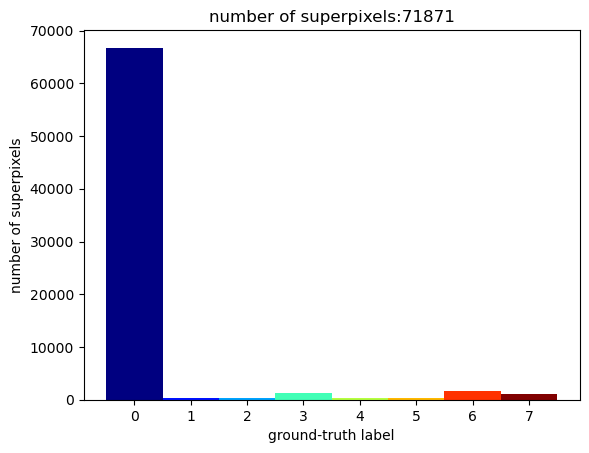

num of bg spp: 66750.0


In [6]:
df_gt = ground_truth_count(superpixels=superpixels,ground_truth=ground_truth)
print('number of superpixels:',df_gt.shape[0])
df_gt

plt.figure()
counts, bins, patches = plt.hist(df_gt.ground_truth, bins=np.linspace(-0.5,7.5,9))#, edgecolor='black')
cmap = plt.cm.get_cmap('jet', 8)
for i in range(8):
    patches[i].set_facecolor(cmap(i))
# plt.hist(df_gt.ground_truth.values,bins= np.linspace(-0.5,7.5,9))
plt.xlabel('ground-truth label')
plt.ylabel('number of superpixels')
plt.title('number of superpixels:'+str(df_gt.shape[0]))
plt.show()

print('num of bg spp:',counts[0])

optionally save them for later

In [28]:
filename = os.path.splitext(os.path.basename(DATA_DIR))[0]

# df_features.to_csv('/Users/teun.huijben/Documents/code/github/superpixels/data/results/' + filename)
# df_gt.to_csv('/Users/teun.huijben/Documents/code/github/superpixels/data/results/gt')

Combine features + gt

In [7]:
df_combined = pd.concat([df_features, df_gt],axis=1)

print(df_features.shape)
print(df_gt.shape)
print(df_combined.shape)
print('max gt',df_combined.ground_truth.max())
# df_combined


(71871, 11)
(71871, 1)
(71871, 12)
max gt 7


Do the evaluation

In [8]:
df_try = df_combined.copy()
print(df_try.shape)
# df_try = df_try[df_try.ground_truth>0]  #remove background superpixels

output = evaluate_spp_features(df_try,
            class_weight = 'balanced',
            n_estimators=50,
            n_jobs=-1,
            max_depth=10,
            max_samples=0.05,)#, class_weight='balanced',kernel='linear')

(71871, 12)


Plot Confusion matrix

8


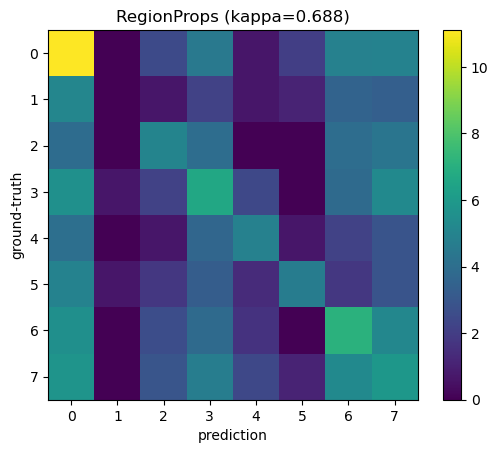

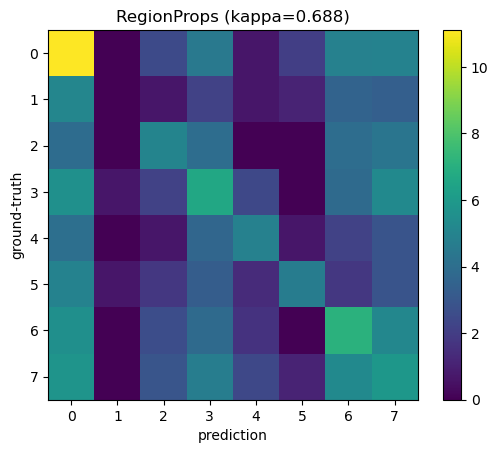

In [9]:
# cm = output.confusion_matrix.to_numpy()[1:,1:]  #exclude background
cm = output.confusion_matrix.to_numpy()

num = cm.shape[0]
print(num)

plt.figure()
# plt.imshow(cm)
plt.imshow(np.log1p(cm),extent=(7.5-num, 7.5, 7.5,7.5-num))
plt.colorbar()
plt.title('RegionProps (kappa='+ str(np.round(output.cohen_kappa,3))+')')
plt.ylabel('ground-truth')
plt.xlabel('prediction')
# plt.clim((0,2000))
plt.show()

plt.figure()
plt.imshow(np.log1p(cm),extent=(7.5-num, 7.5, 7.5,7.5-num))
plt.colorbar()
plt.title('RegionProps (kappa='+ str(np.round(output.cohen_kappa,3))+')')
plt.ylabel('ground-truth')
plt.xlabel('prediction')
plt.show()

Relabel images based on y_pred

In [13]:
class_labels = output.y_pred.y_pred.values
gt_labels = df_gt.ground_truth.values

spp_gt = gt_labels[superpixels-1]
spp_relabeled = class_labels[superpixels-1]

print(superpixels.shape)
print(spp_relabeled.shape)

(200, 630, 630)
(200, 630, 630)


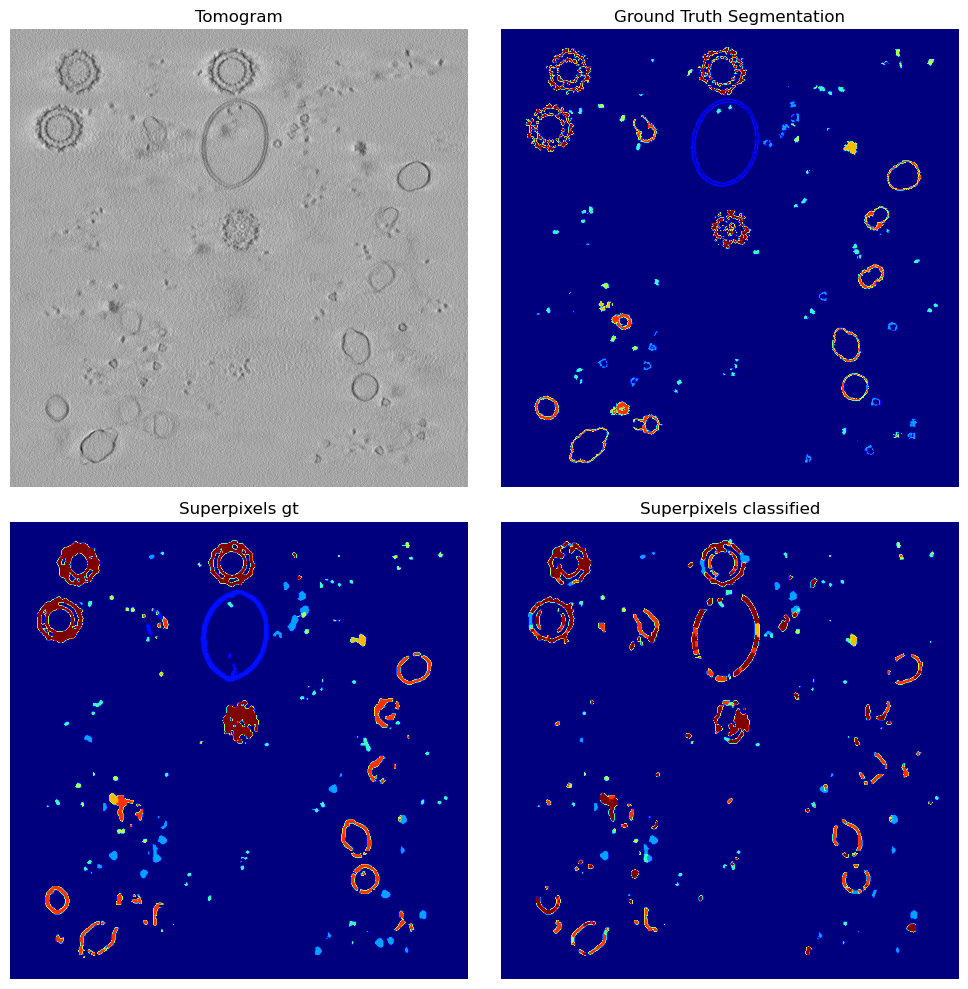

In [11]:
# Plot the images
z_slice = 62

plt.figure(figsize=(10,10))

plt.subplot(2,2, 1)
plt.title('Tomogram')
plt.imshow(tomogram[z_slice],cmap="gray")
plt.axis('off')

plt.subplot(2,2, 2)
plt.title('Ground Truth Segmentation')
plt.imshow(ground_truth[z_slice], cmap="jet")
plt.axis('off')

plt.subplot(2,2, 3)
plt.title('Superpixels gt')
plt.imshow(spp_gt[z_slice], cmap="jet")
plt.axis('off')

plt.subplot(2,2, 4)
plt.title('Superpixels classified')
plt.imshow(spp_relabeled[z_slice], cmap="jet")
plt.axis('off')

plt.tight_layout()
plt.show()

In [14]:
viewer = napari.Viewer()

viewer.add_image(tomogram,name='tomogram')
viewer.add_labels(spp_relabeled,name='spp classified',visible=True)
layer_spp_gt = viewer.add_labels(spp_gt,name='spp gt',visible=True)
layer_spp = viewer.add_labels(superpixels,name='superpixels')
viewer.add_labels(ground_truth.astype('int'),name='ground_truth')

viewer.grid.enabled = True
viewer.grid.shape=(2,2)

# Final figure:

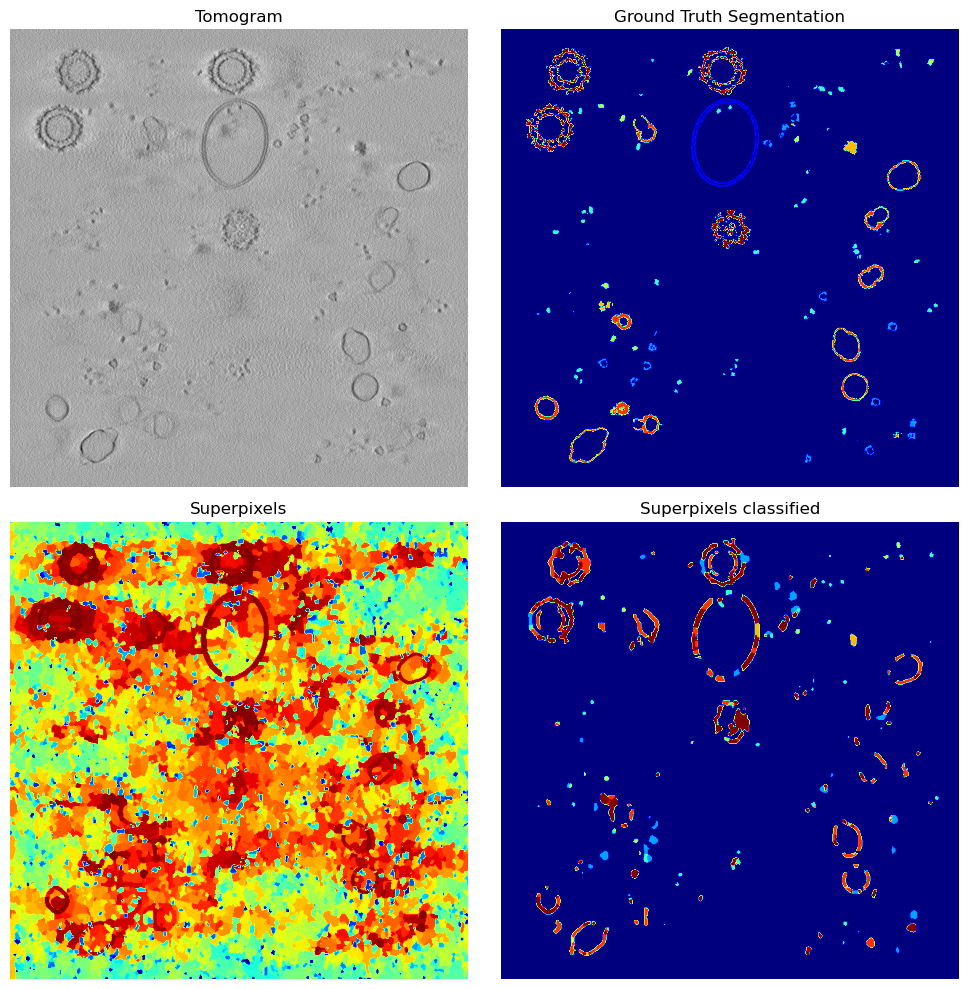

In [26]:
# Plot the images
z_slice = 62

plt.figure(figsize=(10,10))

plt.subplot(2,2, 1)
plt.title('Tomogram')
plt.imshow(tomogram[z_slice],cmap="gray")
plt.axis('off')

plt.subplot(2,2, 2)
plt.title('Ground Truth Segmentation')
plt.imshow(ground_truth[z_slice], cmap="jet")
plt.axis('off')

plt.subplot(2,2, 3)
plt.title('Superpixels')
plt.imshow(superpixels[z_slice], cmap="jet")
plt.axis('off')

plt.subplot(2,2, 4)
plt.title('Superpixels classified')
plt.imshow(spp_relabeled[z_slice], cmap="jet")
plt.axis('off')

plt.tight_layout()
plt.show()